Name: Ishant Rawat

Student Number: 1007084824

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
mth_rolling_features = pd.read_excel('/content/mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('/content/mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('/content/days_since_last_txn.xlsx')
retail_data_response = pd.read_csv('/content/Retail_Data_Response (1).csv')

In [3]:
mth_rolling_features.fillna(0,inplace=True)
mth_rolling_features.drop('Unnamed: 0',axis=1,inplace = True)
mth_day_counts.drop('Unnamed: 0',axis=1,inplace = True)
monthly_features_outputs = mth_rolling_features.merge(mth_day_counts,on = ['CLNT_NO',"ME_DT"])
days_since_last_txn.drop('Unnamed: 0',axis=1,inplace = True)
monthly_features_outputs = monthly_features_outputs.merge(days_since_last_txn,on = ['CLNT_NO',"ME_DT"])
monthly_features_outputs.rename({'CLNT_NO':'customer_id'},axis=1,inplace=True)
monthly_features_outputs=monthly_features_outputs.merge(retail_data_response,on='customer_id')
monthly_features_outputs.shape

(323548, 31)

In [4]:
monthly_features_outputs.isnull().sum()

customer_id            0
ME_DT                  0
mth_txn_amt_sum        0
mth_txn_cnt            0
amt_sum_3M             0
amt_mean_3M            0
amt_max_3M             0
txn_cnt_sum_3M         0
txn_cnt_mean_3M        0
txn_cnt_max_3M         0
amt_sum_6M             0
amt_mean_6M            0
amt_max_6M             0
txn_cnt_sum_6M         0
txn_cnt_mean_6M        0
txn_cnt_max_6M         0
amt_sum_12M            0
amt_mean_12M           0
amt_max_12M            0
txn_cnt_sum_12M        0
txn_cnt_mean_12M       0
txn_cnt_max_12M        0
cnt_Friday             0
cnt_Monday             0
cnt_Saturday           0
cnt_Sunday             0
cnt_Thursday           0
cnt_Tuesday            0
cnt_Wednesday          0
days_since_last_txn    0
response               0
dtype: int64

1. Split the train/test sets with 9:1 ratio. This split should give you approximately 291k/32k samples in train/test set, respectively.

In [5]:
train,test = train_test_split(monthly_features_outputs, test_size=0.1, random_state = 1147)

In [6]:
X_train = train.iloc[:,2:-1]
y_train = train.iloc[:,-1]
x_test = test.iloc[:,2:-1]
y_test = test.iloc[:,-1]

In [7]:
monthly_features_outputs.response.value_counts()

0    293139
1     30409
Name: response, dtype: int64

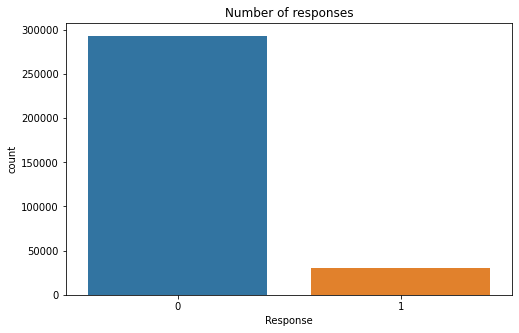

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(monthly_features_outputs.response)
plt.xlabel('Response')
plt.title('Number of responses')
plt.show()

From the figure we can observe that we have an imbalanced dataset. We will perform random oversampling to handle the imbalanced dataset.

2. Initialize and create a for loop in which you take N samples (e.g. 50), build a tree model with the N samples and evaluate the test set AUC. Repeat the sampling process 10 times and append the test set AUC. The following table shows the desired output:

In [9]:
oversample = RandomOverSampler(sampling_strategy='minority') # random sampling to handle class imbalance
X_train_sm,y_train_sm=oversample.fit_resample(X_train,y_train)

Grid Seach for best model

In [10]:
parameters = {'max_depth':[1,3,5,6,8,10]}

clf_dt = DecisionTreeClassifier()
clf = GridSearchCV(clf_dt, parameters, cv=10, n_jobs=-1)
clf.fit(X_train_sm, y_train_sm)

print('The best cross-validation score: {}%'.format(round(clf.best_score_*100,2)))
print('The best parameter:\n', clf.best_params_)

The best cross-validation score: 62.12%
The best parameter:
 {'max_depth': 10}


In [48]:
def sample(N):

  auc_train = []
  auc_test = []
  
  print("------------N = {}--------------------".format(N))
  for i  in range(10): 
    X_train = X_train_sm.sample(n = N)
    indx = X_train.index
    y_train = y_train_sm[indx]
    dt = DecisionTreeClassifier(max_depth = 10, random_state=0)
    dt.fit(X_train, y_train)
    # Score train and test set 
    scores_train = dt.predict_proba(X_train)[:,1] 
    scores_test  = dt.predict_proba(x_test)[:,1]
    # ROC Calc Train set 
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    # ROC Calc Test set w
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))

    print("sample = {}".format(i))
    print("Test AUC = {}".format(auc_test[i]))
  
    print("------------------------------------")
  mean_auc = np.mean(auc_test)
  std_auc = np.std(auc_test)
  print("Mean auc for {} samples is {}".format(N,mean_auc))
  print("Mean std for {} samples is {}".format(N,round(std_auc,6)))
  return mean_auc, std_auc,auc_train,auc_test

In [49]:
mean_auc_50, std_auc_50,auc_train_50,auc_test_50 = sample(N=50)

------------N = 50--------------------
sample = 0
Test AUC = 0.5646658070435023
------------------------------------
sample = 1
Test AUC = 0.5306239633476075
------------------------------------
sample = 2
Test AUC = 0.5095316694683669
------------------------------------
sample = 3
Test AUC = 0.5391638533121131
------------------------------------
sample = 4
Test AUC = 0.5252594393056632
------------------------------------
sample = 5
Test AUC = 0.5516808802839553
------------------------------------
sample = 6
Test AUC = 0.5251314580122566
------------------------------------
sample = 7
Test AUC = 0.5408506633176793
------------------------------------
sample = 8
Test AUC = 0.4956647581540665
------------------------------------
sample = 9
Test AUC = 0.5190188995891151
------------------------------------
Mean auc for 50 samples is 0.5301591391834326
Mean std for 50 samples is 0.019074


3. Repeat the procedure you performed in the previous step for different sample size N
(e.g. 100, 500, 1000, 2000, 5000, 10000) 

# N=100

In [36]:
mean_auc_100, std_auc_100,auc_train_100,auc_test_100 = sample(N=100)

------------N = 100--------------------
sample = 0
Test AUC = 0.5304545970726195
------------------------------------
sample = 1
Test AUC = 0.5395440883192875
------------------------------------
sample = 2
Test AUC = 0.5296273058086097
------------------------------------
sample = 3
Test AUC = 0.4681812313122865
------------------------------------
sample = 4
Test AUC = 0.5065781758274339
------------------------------------
sample = 5
Test AUC = 0.5368998967892795
------------------------------------
sample = 6
Test AUC = 0.5373784588877297
------------------------------------
sample = 7
Test AUC = 0.5196026750876173
------------------------------------
sample = 8
Test AUC = 0.5293275527871091
------------------------------------
sample = 9
Test AUC = 0.5170223119760797
------------------------------------
Mean auc for 100 samples is 0.5214616293868052
Mean std for 100 samples is 0.020277


# N = 500

In [37]:
mean_auc_500, std_auc_500,auc_train_500,auc_test_500 = sample(N=500)

------------N = 500--------------------
sample = 0
Test AUC = 0.5407875453469866
------------------------------------
sample = 1
Test AUC = 0.5502711001591515
------------------------------------
sample = 2
Test AUC = 0.5410778220020642
------------------------------------
sample = 3
Test AUC = 0.5504751105529465
------------------------------------
sample = 4
Test AUC = 0.5510774360107518
------------------------------------
sample = 5
Test AUC = 0.5324175251243983
------------------------------------
sample = 6
Test AUC = 0.5458687741419385
------------------------------------
sample = 7
Test AUC = 0.5351943186554077
------------------------------------
sample = 8
Test AUC = 0.5318866695942336
------------------------------------
sample = 9
Test AUC = 0.5500991438265165
------------------------------------
Mean auc for 500 samples is 0.5429155445414395
Mean std for 500 samples is 0.007332


# N = 1000

In [38]:
mean_auc_1000, std_auc_1000,auc_train_1000,auc_test_1000 = sample(N=1000)

------------N = 1000--------------------
sample = 0
Test AUC = 0.5472438430190114
------------------------------------
sample = 1
Test AUC = 0.5531289966183804
------------------------------------
sample = 2
Test AUC = 0.5463585299884482
------------------------------------
sample = 3
Test AUC = 0.5488924231024191
------------------------------------
sample = 4
Test AUC = 0.5518794812052997
------------------------------------
sample = 5
Test AUC = 0.5575956377387622
------------------------------------
sample = 6
Test AUC = 0.5511194027763404
------------------------------------
sample = 7
Test AUC = 0.5461572886627639
------------------------------------
sample = 8
Test AUC = 0.5342827134629854
------------------------------------
sample = 9
Test AUC = 0.5410624047258763
------------------------------------
Mean auc for 1000 samples is 0.5477720721300288
Mean std for 1000 samples is 0.006216


#N = 2000

In [39]:
mean_auc_2000, std_auc_2000,auc_train_2000,auc_test_2000 = sample(N=2000)

------------N = 2000--------------------
sample = 0
Test AUC = 0.554706431230613
------------------------------------
sample = 1
Test AUC = 0.5656903566503786
------------------------------------
sample = 2
Test AUC = 0.5555493635338903
------------------------------------
sample = 3
Test AUC = 0.5586773028717194
------------------------------------
sample = 4
Test AUC = 0.566599903222468
------------------------------------
sample = 5
Test AUC = 0.5639791173105915
------------------------------------
sample = 6
Test AUC = 0.5674449444927709
------------------------------------
sample = 7
Test AUC = 0.5757418109705443
------------------------------------
sample = 8
Test AUC = 0.5791808313357817
------------------------------------
sample = 9
Test AUC = 0.5684942031377178
------------------------------------
Mean auc for 2000 samples is 0.5656064264756475
Mean std for 2000 samples is 0.007552


# N = 5000

In [40]:
mean_auc_5000, std_auc_5000,auc_train_5000,auc_test_5000 = sample(N=5000)

------------N = 5000--------------------
sample = 0
Test AUC = 0.5794947205898395
------------------------------------
sample = 1
Test AUC = 0.5796255380802805
------------------------------------
sample = 2
Test AUC = 0.5977325192086619
------------------------------------
sample = 3
Test AUC = 0.5869738672693352
------------------------------------
sample = 4
Test AUC = 0.5810834664257484
------------------------------------
sample = 5
Test AUC = 0.5769199179908312
------------------------------------
sample = 6
Test AUC = 0.5878513653743416
------------------------------------
sample = 7
Test AUC = 0.5860714363631787
------------------------------------
sample = 8
Test AUC = 0.5897327429717416
------------------------------------
sample = 9
Test AUC = 0.5939766782930234
------------------------------------
Mean auc for 5000 samples is 0.5859462252566983
Mean std for 5000 samples is 0.006396


# N = 10000

In [41]:
mean_auc_10000, std_auc_10000,auc_train_10000,auc_test_10000 = sample(N=10000)

------------N = 10000--------------------
sample = 0
Test AUC = 0.6026120927162322
------------------------------------
sample = 1
Test AUC = 0.5978419505427653
------------------------------------
sample = 2
Test AUC = 0.5940388844291662
------------------------------------
sample = 3
Test AUC = 0.5923357620950938
------------------------------------
sample = 4
Test AUC = 0.5968611969646539
------------------------------------
sample = 5
Test AUC = 0.595353923266046
------------------------------------
sample = 6
Test AUC = 0.6017778647967532
------------------------------------
sample = 7
Test AUC = 0.597887654151784
------------------------------------
sample = 8
Test AUC = 0.5991287896375317
------------------------------------
sample = 9
Test AUC = 0.5870082149020617
------------------------------------
Mean auc for 10000 samples is 0.5964846333502087
Mean std for 10000 samples is 0.004368


#N = 25000

In [42]:
mean_auc_25000, std_auc_25000,auc_train_25000,auc_test_25000 = sample(N=25000)

------------N = 25000--------------------
sample = 0
Test AUC = 0.6123694720030431
------------------------------------
sample = 1
Test AUC = 0.6188223349117954
------------------------------------
sample = 2
Test AUC = 0.6176543587649397
------------------------------------
sample = 3
Test AUC = 0.6205606495842202
------------------------------------
sample = 4
Test AUC = 0.6149581255366818
------------------------------------
sample = 5
Test AUC = 0.6198276408938216
------------------------------------
sample = 6
Test AUC = 0.6194608092951184
------------------------------------
sample = 7
Test AUC = 0.6176255101098956
------------------------------------
sample = 8
Test AUC = 0.6159670229161364
------------------------------------
sample = 9
Test AUC = 0.6164510224574221
------------------------------------
Mean auc for 25000 samples is 0.6173696946473074
Mean std for 25000 samples is 0.002377


#N = 50000

In [43]:
mean_auc_50000, std_auc_50000,auc_train_50000,auc_test_50000 = sample(N=50000)

------------N = 50000--------------------
sample = 0
Test AUC = 0.6303239529985651
------------------------------------
sample = 1
Test AUC = 0.6288891785377643
------------------------------------
sample = 2
Test AUC = 0.6322531319838556
------------------------------------
sample = 3
Test AUC = 0.6285454952296509
------------------------------------
sample = 4
Test AUC = 0.6230005174521216
------------------------------------
sample = 5
Test AUC = 0.6236664923179338
------------------------------------
sample = 6
Test AUC = 0.6290845964293006
------------------------------------
sample = 7
Test AUC = 0.6336445411598202
------------------------------------
sample = 8
Test AUC = 0.633551444530531
------------------------------------
sample = 9
Test AUC = 0.6187996733059037
------------------------------------
Mean auc for 50000 samples is 0.6281759023945447
Mean std for 50000 samples is 0.004653


# N = 100000

In [44]:
mean_auc_100000, std_auc_100000,auc_train_100000,auc_test_100000 = sample(N=100000)

------------N = 100000--------------------
sample = 0
Test AUC = 0.6287819904285342
------------------------------------
sample = 1
Test AUC = 0.6389176859541118
------------------------------------
sample = 2
Test AUC = 0.6339163461726722
------------------------------------
sample = 3
Test AUC = 0.6387981796873471
------------------------------------
sample = 4
Test AUC = 0.6376280721971577
------------------------------------
sample = 5
Test AUC = 0.6340695064066166
------------------------------------
sample = 6
Test AUC = 0.6399000226560119
------------------------------------
sample = 7
Test AUC = 0.6374234632371245
------------------------------------
sample = 8
Test AUC = 0.6412977475448994
------------------------------------
sample = 9
Test AUC = 0.634021201551797
------------------------------------
Mean auc for 100000 samples is 0.6364754215836272
Mean std for 100000 samples is 0.003551


4. Build a table that contains the values of:

Sample size N

Test AUC mean

Test AUC standard deviation

# Summary Table

| Sample size | Test AUC-Mean | Test AUC-STD |
| --- | --- | --- |
|50|0.53|0.019|
| 100 | 0.52 | 0.020 |
| 500 |0.542 | 0.007 |
| 1000 |0.547 | 0.006 |
| 2000 | 0.56 | 0.0073 |
| 5000 | 0.585| 0.0063 |
| 10000 | 0.596 | 0.0043|
|25000|0.617|0.0023|
|50000|0.62|0.004|
|100000|0.63|0.0035|

In [50]:
samples = [50,100,500,1000,2000,5000,10000,25000,50000,1000000]
mean_auc_ = [mean_auc_50,mean_auc_100,mean_auc_500,mean_auc_1000,mean_auc_2000,mean_auc_5000,mean_auc_10000,mean_auc_25000,mean_auc_50000,mean_auc_100000]
std_auc_ = [std_auc_50,std_auc_100,std_auc_500,std_auc_1000,std_auc_2000,std_auc_5000,std_auc_10000,std_auc_25000,std_auc_50000,std_auc_100000]
table = {'Sample_size   ': samples,
         'Test_AUC_mean  ': mean_auc_,
          'Test_AUC_STD ':  std_auc_}
table = pd.DataFrame(table)


In [51]:
table

,Sample_size,Test_AUC_mean,Test_AUC_STD
0,50,0.530159,0.019074
1,100,0.521462,0.020277
2,500,0.542916,0.007332
3,1000,0.547772,0.006216
4,2000,0.565606,0.007552
5,5000,0.585946,0.006396
6,10000,0.596485,0.004368
7,25000,0.617370,0.002377
8,50000,0.628176,0.004653
9,1000000,0.636475,0.003551


5. Using the matplotlib function errorbar, plot the model performance captured in the
test AUC mean and standard deviation as a function of the sample size. From this
plot, can you estimate what is the minimum number of samples needed to model the
behaviour adequately?

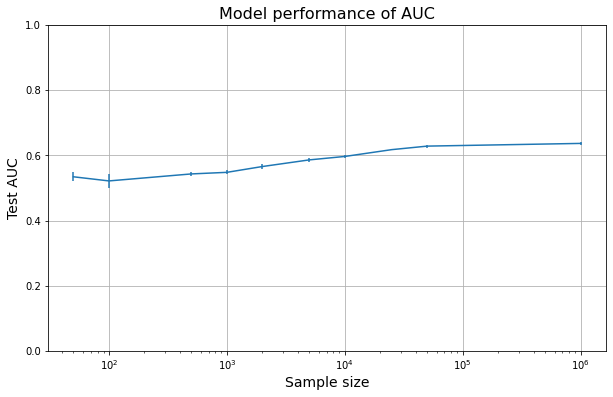

In [47]:
fig = plt.figure(figsize=(10,6))
plt.errorbar(samples, mean_auc_, yerr=std_auc_)
plt.xscale('log')
plt.ylim((0,1))
plt.xlabel('Sample size', fontsize=14)
plt.ylabel('Test AUC', fontsize=14)
plt.title('Model performance of AUC', fontsize=16)
plt.grid()
plt.show()

From the plot we can observe that the model performance improves slightly until a certain point in the graph (about 55000) samples. After this point, the perfromance of the model remains constant. Thus, we can say that the minimum number of samples required for the model to perform well is about 50000 where the auc is about 0.63. It is important to note that if we give more samples than required to our model it may lead to overfitting.